# Quantum-Classical Hybrid Computing: Getting Started

D-Wave offers two complementary approaches to hybrid computing: 

* [Leap Quantum Application Environment](https://cloud.dwavesys.com/leap) maintains state-of-the-art hybrid solvers.
* Ocean software's [*dwave-hybrid*](https://docs.ocean.dwavesys.com/en/stable/docs_hybrid/sdk_index.html) provides reference
  samplers and a Python framework for developing custom hybrid workflows and components.

These notebooks demonstrate how you can apply Leap's cloud-based hybrid solvers and the *dwave-hybrid* Python framework's samplers to your problem, create hybrid workflows, and develop custom hybrid components, expanding the content presented in the D-Wave webinar [Hybrid Quantum Programming](https://www.youtube.com/watch?v=EW44reo8Bn0).

This first notebook starts you off with Leap's hybrid solvers and *dwave-hybrid*'s out-of-the-box reference samplers and workflows:

1. [A Few Words on Hybrid Computing](#A-Few-Words-on-Hybrid-Computing) section gives a very short introduction to quantum-classical hybrid computing. 
2. [A Sample Problem](#A-Sample-Problem) section provides an example problem used throughout the notebooks.
3. [Using Leap's Hybrid Solvers](#Using-Leap's-Hybrid-Solvers) section demonstrates using Leap's cloud-based hybrid solvers.
4. [Reference Samplers and Workflows](#Reference-Samplers-and-Workflows) section demonstrates using *dwave-hybrid* reference samplers and workflows. 
5. [Operational Utilities](#Operational-Utilities) section shows utilities to help your coding. 

More-advanced content is provided in the following notebooks:

* [Quantum-Classical Hybrid Computing: Workflows](02-hybrid-computing-workflows.ipynb) notebook shows how you use *dwave-hybrid* components to create custom workflows for your problem.
* [Quantum-Classical Hybrid Computing: Components](03-hybrid-computing-components.ipynb) notebook shows how to develop your own hybrid components for optimal performance. 

## Prerequisite Knowledge

These notebooks assume basic familiarity with [Ocean Software](https://docs.ocean.dwavesys.com/en/stable/index.html) and its binary quadratic model ([BQM](https://docs.ocean.dwavesys.com/en/stable/concepts/bqm.html)) approach to formulating problems on quantum computers. [Leap's](https://cloud.dwavesys.com/leap) *Structural Imbalance* and *Factoring* Jupyter Notebooks are good introductions to the basics of solving problems on a quantum computer, as is the [Getting Started with the D-Wave System](https://docs.dwavesys.com/docs/latest/doc_getting_started.html) guide. For an introduction to Ocean software, see [Ocean Software documentation](https://docs.ocean.dwavesys.com/en/stable/getting_started.html#gs). 

**New to Jupyter Notebooks?** JNs are divided into text or code cells. Pressing the **Run** button in the menu bar moves to the next cell. Code cells are marked by an "In: \[\]" to the left; when run, an asterisk displays until code completion: "In: \[\*\]".

# A Few Words on Hybrid Computing
Quantum-classical hybrid is the use of both classical and quantum resources to solve problems, exploiting the complementary strengths that each provides. As quantum processors grow in size, offloading hard optimization problems to quantum computers promises performance benefits similar to CPUs' outsourcing of compute-intensive graphics-display processing to GPUs. 

This [Medium Article](https://medium.com/d-wave/three-truths-and-the-advent-of-hybrid-quantum-computing-1941ba46ff8c) provides an overview of, and motivation for, hybrid computing. 

D-Wave's [Leap quantum cloud service](https://cloud.dwavesys.com/leap) provides cloud-based hybrid solvers you can submit arbitrary BQMs to. These solvers, which implement state-of-the-art classical algorithms together with intelligent allocation of the quantum processing unit (QPU) to parts of the problem where it benefits most, are designed to accommodate even very large problems. Leap's solvers can relieve you of the burden of any current and future development and optimization of hybrid algorithms that best solve your problem. 

[*dwave-hybrid*](https://docs.ocean.dwavesys.com/en/stable/docs_hybrid/sdk_index.html) provides you with a Python framework for building a variety of flexible hybrid workflows. These use quantum and classical resources together to find good solutions to your problem. For example, a hybrid workflow might use classical resources to find a problem’s hard core and send that to the QPU, or break a large problem into smaller pieces that can be solved on a QPU and then recombined.

The *dwave-hybrid* framework enables rapid development of experimental prototypes, which provide insight into expected performance of the productized versions. It provides reference samplers and workflows you can quickly plug into your application code. You can easily experiment with customizing workflows that best solve your problem. You can also develop your own hybrid components to optimize performance.  

# A Sample Problem
This section creates an example problem used in the following sections and notebooks.  

Each of the two sets of nodes in the illustrative graph below, one red and the other blue, form an *independent set*; that is, a set of vertices with no edge connecting any of its member pairs. 

<img src="images/cover.png" width=200x>

Such a graph might represent the problem of [antenna selection](https://github.com/dwave-examples/antenna-selection), finding good coverage for a sprinkler system, or many other real-world optimization problems. If the graph represents a sprinkler system, with edges corresponding to overlaps in sprinklers' watering, a [maximum independent set](https://en.wikipedia.org/wiki/Independent_set_(graph_theory)) solves the problem of watering a lawn evenly with the lowest number of sprinklers.  

The first code cell below uses [networkx](https://networkx.github.io) to build a random sparse graph&mdash;the `random_geometric_graph()` function places uniformly at random a specified number of nodes, `problem_node_count`, in a unit cube, joining edges of any two if  the distance is below a given `radius`&mdash;and utility graphics code to plot it. To see this graphics code, select **Jupyter File Explorer View** from the Online Learning page and navigate to the folder for this notebook.

<div class="alert alert-warning" role="alert" style="margin: 10px">Note: Problem size (nodes and density of edges) selected below ensures that runtimes on compute resources (virtual CPUs) provided by the Leap environment do not exceed a few minutes.</div>

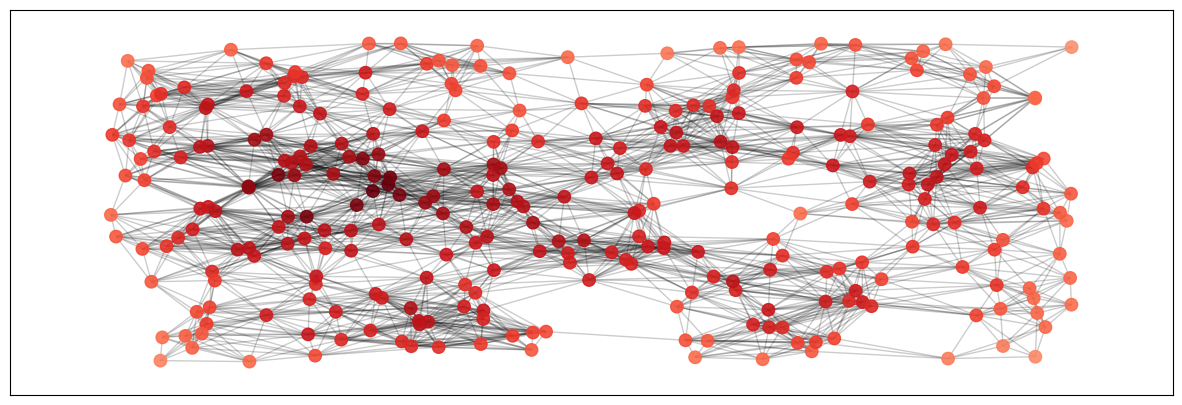

In [1]:
import networkx as nx
from helpers.draw import plot    
%matplotlib inline

problem_node_count = 300

G = nx.random_geometric_graph(problem_node_count, radius=0.0005*problem_node_count)

plot(G)

As with solving any problem on the quantum computer, the first step of finding the graph's maximum independent set is to [formulate the problem as a BQM](https://docs.ocean.dwavesys.com/en/stable/overview/solving_problems.html). Use Ocean software's [dwave_networkx](https://docs.ocean.dwavesys.com/en/stable/docs_dnx/sdk_index.html) and [dimod](https://docs.ocean.dwavesys.com/en/stable/docs_dimod/sdk_index.html) to create and hold an appropriate BQM. 

In [2]:
import dwave_networkx as dnx
import dimod

qubo = dnx.algorithms.independent_set.maximum_weighted_independent_set_qubo(G)
bqm = dimod.BQM.from_qubo(qubo)

print("BQM sets all node biases to {} and edge biases to {}.".format(
       bqm.linear[list(G.edges)[0][0]], bqm.quadratic[list(G.edges)[0]]))

BQM sets all node biases to -1.0 and edge biases to 2.0.


# Using Leap's Hybrid Solvers
D-Wave's [Leap quantum cloud service](https://cloud.dwavesys.com/leap) provides state-of-the-art hybrid solvers you can submit arbitrary BQMs to, efficiently outsourcing the development and optimization of hybrid algorithms to D-Wave's scientists with their many years of expertise in this field. This enables you to deploy a tested hybrid solver to solve your application code's BQM with minimal code updates.

This section provides a demonstration of using a Leap hybrid solver.

<div class="alert alert-warning" role="alert" style="margin: 10px">Note: Not all accounts have access to this type of solver. This is the only section of the Hybrid Computing notebooks that uses these solvers&mdash;if you do not see solvers in the Hybrid section of Supported Solvers in your Leap dashboard, skip to the next section. </div>

Run `LeapHybridSampler` with its default parameters on the BQM representing the problem graph. 

The resulting samples represent nodes of a maximum independent set with ones. The `print` line below uses [NumPy](https://numpy.org/) to count and report the size of the set. 

In [6]:
from dwave.system import LeapHybridSampler
import numpy as np
token='45FS-23cfb48dca2296ed24550846d2e7356eb6c19551'
result = LeapHybridSampler(token=token).sample(bqm, label='Notebook - Hybrid Computing 1')
print("Found solution with {} nodes at energy {}.".format(np.sum(result.record.sample), 
                                                          result.first.energy))

Found solution with 40 nodes at energy -40.0.


Plot the problem with the selected nodes colored deeper red than the background graph.  

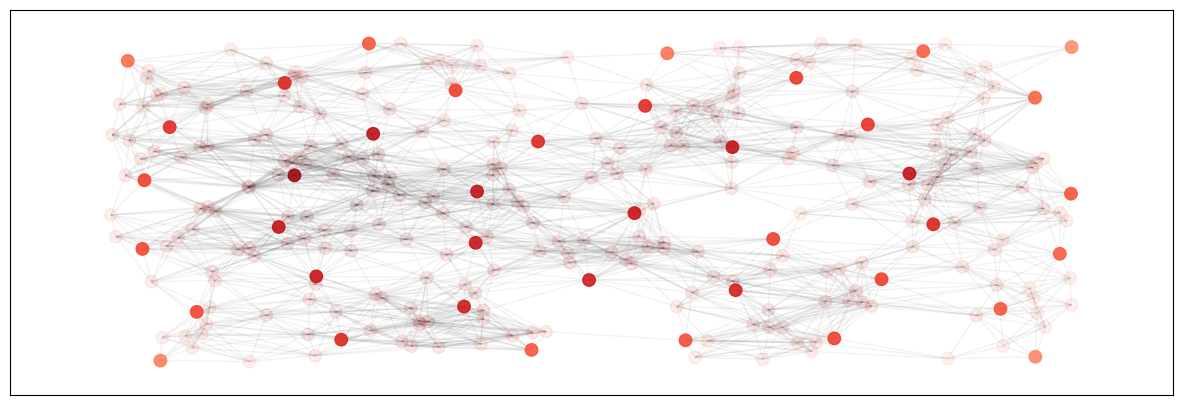

In [7]:
plot(G, subgraphs=[G.subgraph(np.flatnonzero(result.record.sample==1))])

# Reference Samplers and Workflows
*dwave-hybrid* provides [reference workflows and samplers](https://docs.ocean.dwavesys.com/en/stable/docs_hybrid/reference/reference.html) that you can import into your application code. These are not optimized to a particular problem, but are a good starting point for your hybrid solution.

The purpose of the rest of this notebook is to show you how you can quickly deploy these ready-made components into your application code. The [Quantum-Classical Hybrid Computing: Workflows](02-hybrid-computing-workflows.ipynb) and [Quantum-Classical Hybrid Computing: Components](03-hybrid-computing-components.ipynb) notebooks will explain the components themselves in more detail than the minimum needed for usage given here.

##  Sampler: Kerberos 
You can run the Kerberos sampler, an out-of-the-box hybrid sampler provided in the *dwave-hybrid* package, in the same way you typically run any dimod sampler. 

Run `KerberosSampler` with its default parameters on the BQM representing the problem graph.  

In [11]:
import hybrid 
import numpy as np

result = hybrid.KerberosSampler().sample(bqm, 
                                         qpu_params={'label': 'Notebook - Hybrid Computing 1'},
                                         )
print("Found solution with {} nodes at energy {}.".format(np.sum(result.record.sample), 

                                                          result.first.energy))

ValueError: API token not defined

### Configuring the Sampler
Kerberos default parameters work reasonably well with a large variety of problems but are not optimized to any particular class of problem. Once your application code runs with a reference sampler, experiment with adjusting its parameters to improve performance.

To configure Kerberos for your application, it's sufficient to know that Kerberos loops over three sampling branches in parallel, selecting after each iteration the best results from tabu search, simulated annealing, and QPU sampling of a subproblem.

<img src="images/kerberos.png" width=500x>

Internally, the Kerberos structure includes the following components:

* *Interruptable Tabu Sampler* and *Interruptable SA Sampler* are classical samplers that 
  run on CPU until interrupted by the QPU branch. 
* *Energy Impact Decomposer* selects a subset of the problem's variables (those that
  maximally contribute to the problem energy); *QPU Sampler* submits subproblems to the
  quantum computer; and *SplatComposer* inserts subproblems' samples into problem  
  samples.
* *ArgMin* selects the best samples from an iteration, which terminates when the quantum 
  computer returns samples. 
* *Loop* iterates these *Racing Branches* until a termination condition is reached.  

The [Quantum-Classical Hybrid Computing: Workflows](02-hybrid-computing-workflows.ipynb) notebook dives into the details of *dwave-hybrid* components and structuring workflows. 


The call below limits the maximum number of iterations to `max_iter=10`.  

In [ ]:
result = hybrid.KerberosSampler().sample(bqm, 
                                         max_iter=10, 
                                         qpu_params={'label': 'Notebook - Hybrid Computing 1'})
print("Found solution with {} nodes at energy {}.".format(np.sum(result.record.sample), 
                                                                 result.first.energy))

<div class="alert alert-success" role="alert" style="margin: 10px"> 
    <b>Exercise</b>: Kerberos provides a large set of 
    <a href="https://docs.ocean.dwavesys.com/en/stable/docs_hybrid/reference/reference.html">configurable parameters</a>. In the placeholder code cell below, experiment with a few: (1) Return more sample sets (2) Increase the number of QPU sample sets (reads) per submission (3) Reduce the tabu search to 200 ms.

Open the hidden code cell below it for a solution.

Remember that for large problems, CPU runtimes can be long.
</div>

In [ ]:
# Placeholder cell for exercise. Modify and run your code here.

result = hybrid.KerberosSampler().sample(bqm, 
                                         max_iter=10, 
                                         qpu_params={'label': 'Notebook - Hybrid Computing 1'})
print("Found solutions with energy", result.record.energy)

In [ ]:
# Click here to see solution:
result = hybrid.KerberosSampler().sample(bqm, 
                                         num_reads=3, 
                                         max_iter=10, 
                                         qpu_reads=100, 
                                         tabu_timeout=200,
                                         qpu_params={'label': 'Notebook - Hybrid Computing 1'})
print("Found solutions with energy {}.".format(result.record.energy))

<div class="alert alert-success" role="alert" style="margin: 10px"> 
    <b>Advanced Exercise</b>: Increase the size of the subproblems submitted to the QPU to 70 variables while ensuring that Kerberos selects a QPU with over 1800 qubits. Open the hidden code cell below it for a solution.

<p> Hint: The <a href="https://docs.ocean.dwavesys.com/en/stable/docs_cloud/sdk_index.html">D-Wave Cloud Client</a> <code>Client.get_solvers()</code> method handles filtering for feature-based selection of QPUs.</p>
</div>

In [ ]:
# Write and run your exercise code here:


In [ ]:
# Click here to see solution:
from dwave.system import DWaveSampler

sampler_qpu = DWaveSampler(solver={'num_qubits__gt':1800})

result = hybrid.KerberosSampler().sample(bqm, max_iter=10, 
                                              max_subproblem_size=70,
                                              qpu_sampler=sampler_qpu,
                                              qpu_params={'label': 'Notebook - Hybrid Computing 1'})
print("Found solution with {} nodes at energy {}.".format(np.sum(result.record.sample), 
                                                                 result.first.energy))

## Workflow: Parallel Tempering 
*dwave-hybrid* provides tested [reference workflows](https://docs.ocean.dwavesys.com/en/stable/docs_hybrid/reference/reference.html) that you can plug into your application code.  

To simply use such workflows, it's sufficient to know that the *dwave-hybrid* workflows comprise two main types of components:

* *State*-class components hold a problem, samples, and optionally additional information.
* *Runnable*-class components take input states, run for an iteration, and output updated states. 

Workflows&mdash;which are themselves Runnables&mdash;input states representing a problem BQM and aim to produce states updated with samples that are good solutions to the problem or parts of it. Sometimes you may be in a position to provide initial samples with values better than random for your problem; for example, if you are intermittently running a very large problem, possibly on more than one solver, and saving intermediate results. Workflows may run for a single iteration or many iterations. 

The [Quantum-Classical Hybrid Computing: Workflows](02-hybrid-computing-workflows.ipynb) notebook dives into the details of *dwave-hybrid* workflows.

[Parallel Tempering (PT)](https://en.wikipedia.org/wiki/Parallel_tempering) runs a number of replicas of simulated annealing at different temperatures and swaps some low- and high-energy samples between replicas. In this way, a low-temperature replica injected with a high-energy sample might escape a local minimum.  

In the next cell, an initial state is produced from the BQM by the `State.from_problem` utility and input into workflow `pt_workflow`, generated by `ParallelTempering`. The example calls two methods:

*  Runnable [run()](https://docs.ocean.dwavesys.com/en/stable/docs_hybrid/reference/core.html) method to execute an iteration of the PT reference workflow (workflows are Runnables).  
* State [result()](https://docs.ocean.dwavesys.com/en/stable/docs_hybrid/reference/core.html) method to resolve the result, which is returned in a [Future](https://docs.python.org/3/library/concurrent.futures.html#concurrent.futures.Future)-like object. 

Note: Because the default PT workflow results in long CPU runtimes on the example problem of this notebook, parameters are specified below for a shorter execution. 

In [12]:
state_start = hybrid.State.from_problem(bqm)

pt_workflow = hybrid.ParallelTempering(num_replicas=3, max_iter=5)

result = pt_workflow.run(state_start, max_time=4).result()
print("Found solution with {} nodes at energy {}.".format(np.sum(result.samples.record.sample),
                                                          result.samples.first.energy))

Found solution with 226 nodes at energy -36.0.


Because the `KerberosSampler` of the [Sampler: Kerberos](#Sampler:-Kerberos) section is itself just a workflow, you can  replace `ParallelTempering` with the [Kerberos reference workflow](https://docs.ocean.dwavesys.com/en/stable/docs_hybrid/reference/reference.html), configuring the appropriate parameters, and run the Kerberos workflow directly instead. 

The [Quantum-Classical Hybrid Computing: Components](03-hybrid-computing-components.ipynb) notebook demonstrates how you can convert hybrid workflows into dimod samplers.   

### Configuring the Workflow
<div class="alert alert-success" role="alert" style="margin: 10px"> 
    <b>Exercise</b>: Try adjusting some workflow parameters and observing the effect on performance. Open the hidden code cell below it for a solution.
    Remember that for large problems, CPU runtimes can be long.
</div>

In [ ]:
# Write and run your exercise code here:


In [13]:
# Click here to see solution:
result = pt_workflow.run(state_start, max_iter=1, max_time=7, num_sweeps=1000).result()
print("Found solution with {} nodes at energy {}.".format(np.sum(result.samples.record.sample), 
                                                                 result.samples.first.energy))

Found solution with 234 nodes at energy -37.0.


You can try other implemented [reference workflows](https://docs.ocean.dwavesys.com/en/stable/docs_hybrid/reference/reference.html), such as hybridized PT and population annealing. In the [Quantum-Classical Hybrid Computing: Workflows](02-hybrid-computing-workflows.ipynb) notebook you will build your own such workflows to best fit your problem.

# Operational Utilities
This section demonstrates a few useful operational utilities that can help you understand and debug your code.

## Structure
The `print_structure` method prints the hybrid workflow's structure of nested components.

In [14]:
hybrid.print_structure(pt_workflow)

Branch
  SpawnParallelTemperingReplicas
  Loop
    Branch
      Map
        FixedTemperatureSampler
      SwapReplicasDownsweep
  MergeSamples


## Counters
The `print_counters` method helps you examine the execution of a hybrid workflow. 

In [15]:
hybrid.print_counters(pt_workflow)

* Branch
  (timers)
  - 'dispatch': cnt = 2, cumtime = 0.007 s, avgtime = 0.003 s
  - 'dispatch.init': cnt = 1, cumtime = 0.000 s, avgtime = 0.000 s
  - 'dispatch.next': cnt = 2, cumtime = 2.820 s, avgtime = 1.410 s
  - 'dispatch.resolve': cnt = 2, cumtime = 0.000 s, avgtime = 0.000 s

    * SpawnParallelTemperingReplicas
      (timers)
      - 'dispatch': cnt = 2, cumtime = 0.042 s, avgtime = 0.021 s
      - 'dispatch.init': cnt = 1, cumtime = 0.000 s, avgtime = 0.000 s
      - 'dispatch.next': cnt = 2, cumtime = 0.042 s, avgtime = 0.021 s
      - 'dispatch.resolve': cnt = 2, cumtime = 0.000 s, avgtime = 0.000 s

    * Loop
      (timers)
      - 'dispatch': cnt = 2, cumtime = 2.758 s, avgtime = 1.379 s
      - 'dispatch.init': cnt = 1, cumtime = 0.000 s, avgtime = 0.000 s
      - 'dispatch.next': cnt = 2, cumtime = 2.758 s, avgtime = 1.379 s
      - 'dispatch.resolve': cnt = 2, cumtime = 0.000 s, avgtime = 0.000 s

        * Branch
          (timers)
          - 'dispatch': cnt = 10,

## Logging
The `logger.setLevel` method sets logging level as described under [Using the Framework](https://docs.ocean.dwavesys.com/en/stable/docs_hybrid/intro/using.html). 

*dwave-hybrid* supports logging levels TRACE, DEBUG, INFO, WARNING, ERROR, and CRITICAL in ascending order of severity. Try setting lower levels to learn what additional information you have available for understanding and debugging your hybrid application code.  

Afterwards, return the logging level to ERROR (the default level) or to any level you prefer for the following notebooks. 

In [16]:
hybrid.logger.setLevel(hybrid.logging.INFO) 

result = pt_workflow.run(state_start, max_iter=1).result()

print("Found solution with {} nodes at energy {}.".format(np.sum(result.samples.record.sample), 
                                                                 result.samples.first.energy))
hybrid.logger.setLevel(hybrid.logging.ERROR) 

2025-11-19 15:54:37,568 hybrid.flow INFO Loop Iteration(iterno=0, input_state_key=0.0, output_state_key=-32.0)
2025-11-19 15:54:37,832 hybrid.flow INFO Loop Iteration(iterno=1, input_state_key=-32.0, output_state_key=-34.0)
2025-11-19 15:54:38,269 hybrid.flow INFO Loop Iteration(iterno=2, input_state_key=-34.0, output_state_key=-35.0)
2025-11-19 15:54:38,534 hybrid.flow INFO Loop Iteration(iterno=3, input_state_key=-35.0, output_state_key=-36.0)
2025-11-19 15:54:38,750 hybrid.flow INFO Loop Iteration(iterno=4, input_state_key=-36.0, output_state_key=-36.0)


Found solution with 221 nodes at energy -36.0.


Copyright &copy; 2020 D-Wave Systems, Inc

The software is licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This Jupyter Notebook is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>